In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite


In [2]:
#Read all the csv files
donations = pd.read_csv('Donations.csv')
donors = pd.read_csv('Donors.csv',low_memory=False)
schools = pd.read_csv('Schools.csv',error_bad_lines=False)
teachers = pd.read_csv('Teachers.csv',error_bad_lines=False)
projects = pd.read_csv('Projects.csv',error_bad_lines=False)
resources = pd.read_csv('Resources.csv',error_bad_lines=False,warn_bad_lines=False)

In [3]:
donors.head()

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip
0,00000ce845c00cbf0686c992fc369df4,Evanston,Illinois,No,602
1,00002783bc5d108510f3f9666c8b1edd,Appomattox,other,No,245
2,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953
3,00002eb25d60a09c318efbd0797bffb5,Indianapolis,Indiana,No,462
4,0000300773fe015f870914b42528541b,Paterson,New Jersey,No,075


In [4]:
projects['Project Title'].nunique()

926127

In [5]:
donations['Donor ID'].nunique()

2024554

In [6]:
donations['Project ID'].nunique()

901965

In [7]:
donors['Donor ID'].nunique()

2122640

In [8]:
donations.shape

(4687884, 7)

In [9]:
donations.head()

,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date
0,000009891526c0ade7180f8423792063,688729120858666221208529ee3fc18e,1f4b5b6e68445c6c4a0509b3aca93f38,No,178.37,11,2016-08-23 13:15:57
1,000009891526c0ade7180f8423792063,dcf1071da3aa3561f91ac689d1f73dee,4aaab6d244bf3599682239ed5591af8a,Yes,25.00,2,2016-06-06 20:05:23
2,000009891526c0ade7180f8423792063,18a234b9d1e538c431761d521ea7799d,0b0765dc9c759adc48a07688ba25e94e,Yes,20.00,3,2016-06-06 14:08:46
3,000009891526c0ade7180f8423792063,38d2744bf9138b0b57ed581c76c0e2da,377944ad61f72d800b25ec1862aec363,Yes,25.00,1,2016-05-15 10:23:04
4,000009891526c0ade7180f8423792063,5a032791e31167a70206bfb86fb60035,6d5b22d39e68c656071a842732c63a0c,Yes,25.00,2,2016-05-17 01:23:38


In [10]:
#donations.loc[donations['Donor ID'].isin((donations.groupby('Donor ID').size().Value >= 1).index)]
df = donations[donations.groupby('Donor ID')['Donor ID'].transform('size') > 5]
df.shape

(2016744, 7)

In [11]:
df.head()

,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date
0,000009891526c0ade7180f8423792063,688729120858666221208529ee3fc18e,1f4b5b6e68445c6c4a0509b3aca93f38,No,178.37,11,2016-08-23 13:15:57
9,00000ce845c00cbf0686c992fc369df4,d5364b1bb3b14594808bd6efa7544165,6dd6113f89f2766d3b0707ef2a46260c,Yes,10.00,44,2013-02-27 10:32:22
19,00002d44003ed46b066607c5455a999a,c40e75f11f570cd590e81a413199e94e,344ad0a72366a27bd4926bbe5d066939,Yes,10.00,9,2017-07-24 08:40:35
21,00002d44003ed46b066607c5455a999a,3971882221203d20f574948d0a6ee28a,3cf2607d4131cd654bf54a1f5a533357,Yes,25.00,5,2017-07-11 16:40:30
24,00002eb25d60a09c318efbd0797bffb5,84e5d5d62368c36ee8252f60cb00f53a,309bbe105f70465277576733c0d451b3,No,10.00,43,2016-07-31 09:35:47


In [12]:
df['Project ID'].nunique()

657105

In [13]:
df_project = pd.merge(df, projects, on='Project ID', how='left')
df_project.shape

(2016746, 24)

In [14]:
df_project.isnull().sum()

Project ID                                  0
Donation ID                                 0
Donor ID                                    0
Donation Included Optional Donation         0
Donation Amount                             0
Donor Cart Sequence                         0
Donation Received Date                      0
School ID                               40773
Teacher ID                              40773
Teacher Project Posted Sequence         40773
Project Type                            40773
Project Title                           40783
Project Essay                           40774
Project Short Description               40775
Project Need Statement                  40774
Project Subject Category Tree           40822
Project Subject Subcategory Tree        40822
Project Grade Level Category            40773
Project Resource Category               40828
Project Cost                            40773
Project Posted Date                     40773
Project Expiration Date           

In [15]:
df_project = df_project.dropna(how='any')

In [16]:
pd.options.display.float_format = "{:.2f}".format
df_project.isnull().sum()

Project ID                             0
Donation ID                            0
Donor ID                               0
Donation Included Optional Donation    0
Donation Amount                        0
Donor Cart Sequence                    0
Donation Received Date                 0
School ID                              0
Teacher ID                             0
Teacher Project Posted Sequence        0
Project Type                           0
Project Title                          0
Project Essay                          0
Project Short Description              0
Project Need Statement                 0
Project Subject Category Tree          0
Project Subject Subcategory Tree       0
Project Grade Level Category           0
Project Resource Category              0
Project Cost                           0
Project Posted Date                    0
Project Expiration Date                0
Project Current Status                 0
Project Fully Funded Date              0
dtype: int64

In [17]:
pd.options.display.float_format = "{:.2f}".format
df_project.describe()

,Donation Amount,Donor Cart Sequence,Teacher Project Posted Sequence,Project Cost
count,1809508.00,1809508.00,1809508.00,1809508.00
mean,66.89,348.95,21.58,712.31
std,183.69,1361.51,41.75,2379.67
min,0.01,1.00,1.00,35.29
25%,5.00,6.00,2.00,315.79
50%,25.00,17.00,5.00,479.61
75%,55.00,109.00,20.00,738.16
max,60000.00,18115.00,497.00,255737.67


In [18]:
print(df_project.shape)
print(df_project['Project ID'].nunique())
print(df_project['Donor ID'].nunique())

(1809508, 24)
554515
98133


In [19]:
df_final = df_project[['Donor ID', 'Project ID', 'Project Title']]


In [34]:
df_final.shape
df_train, df_test = train_test_split(df_final, test_size=0.20, random_state=42)

In [290]:
#print(df_train.head())
df_train["is_duplicate"]= df_train.duplicated()

df_train.drop(df_train[df_train['is_duplicate'] == True].index, inplace=True)
print((df_train["is_duplicate"] == True).sum())

C:\Users\Reena\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0


C:\Users\Reena\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [284]:
#Faulty records
#df_test_bg = df_train.head(14620)
#df_test = df_test_bg.drop(df_test_bg[(df_test_bg['Donor ID'] == '9d7051e2611cebdb758f1c7bd09360ac') & (df_test_bg['Project ID'] == '2bb67f3bcc240531041a27d361035dc7')].index)
#df_test_bg = df_train.head(31949)

In [293]:
df_test_bg = df_train.head(10)

G = nx.Graph()
G.add_nodes_from(df_test_bg['Donor ID'], bipartite=0)
G.add_nodes_from(df_test_bg['Project ID'], bipartite=1)
G.add_edges_from([(row['Donor ID'], row['Project ID']) for idx, row in df_test_bg.iterrows()])

bipartite.is_bipartite(G)

True

In [294]:
#print(df_test_bg.tail())

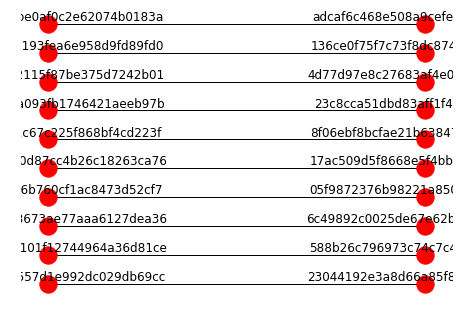

In [295]:
pos = {node:[0, i] for i,node in enumerate(df_test_bg['Donor ID'])}
pos.update({node:[1, i] for i,node in enumerate(df_test_bg['Project ID'])})
nx.draw(G, pos, with_labels=False)
for p in pos:  # raise text positions
    pos[p][1] += 0.25
nx.draw_networkx_labels(G, pos)

plt.show()
